In [42]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from random import seed,sample
import datetime as dt
from datetime import datetime
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler # Undersampling for Unbalanced Data
from imblearn.over_sampling import SMOTE # Oversampling for Unbalanced Data
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler # Data Encoders
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [4]:
X_train = pd.read_csv('../X_train.csv')
X_val = pd.read_csv('../X_val.csv')
y_train = pd.read_csv('../y_train.csv')
y_val = pd.read_csv('../y_val.csv')

# test set only for one-time assessment of final model
X_test = pd.read_csv('../X_test.csv')
y_test = pd.read_csv('../y_test.csv')

Scale the features below only, we don't scale the hour_of_day since the values are already within a similar range and have a clear numerical interpretation (hours of the day)

In [48]:
from sklearn.preprocessing import StandardScaler

features_to_scale = ["amount(usd)", "lat", "long", "merch_lat", "merch_long", "age"]


# Initialize the StandardScaler and fit/transform on numerical features
scaler = StandardScaler()

# Fit and transform the scaler on the selected features in your training data
X_train_scaled = X_train.copy()
X_train_scaled[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Transform the same selected features in validation data using the same scaler
X_val_scaled = X_val.copy()
X_val_scaled[features_to_scale] = scaler.transform(X_val[features_to_scale])

# Transform the same selected features in test data using the same scaler
X_test_scaled = X_test.copy()
X_test_scaled[features_to_scale] = scaler.transform(X_test[features_to_scale])

In [49]:
X_test_scaled.head()

,category,amount(usd),gender,state,lat,long,job,merch_lat,merch_long,hour_of_day,day_of_week,age,job_categories
1519040,shopping_pos,-0.437322,F,NY,1.250101,1.206416,"Surveyor, land/geomatics",1.209293,1.253763,8,Tuesday,1.194640,C2
464165,shopping_pos,-0.436237,F,MO,-0.349648,-0.276857,Production manager,-0.534726,-0.340737,18,Tuesday,-0.702057,C3
119190,food_dining,-0.394625,F,TX,-1.617997,-0.347429,Building surveyor,-1.452376,-0.415589,14,Friday,-1.276813,C2
1567844,shopping_pos,-0.383903,M,MS,-0.997472,-0.019935,Chartered public finance accountant,-1.033834,0.035471,14,Tuesday,-1.449240,C3
1244301,entertainment,-0.433110,M,CA,-0.950562,-1.896804,Learning mentor,-1.097084,-1.871424,10,Tuesday,1.079689,C1


In [50]:
unqiue_state = X_test_scaled['state'].nunique()
unique_category = X_test_scaled['category'].nunique()
unique_job = X_test_scaled['job'].nunique()

print("no of unqiue sates: ", unqiue_state)
print("no of unqiue categories: ", unique_category)
print("no of unqiue jobs: ", unique_job)

no of unqiue sates:  51
no of unqiue categories:  14
no of unqiue jobs:  488


We will then be one hot encoding some of our categorical variables to run a logistic regression model on X and y.

In [51]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder with sparse=False and drop='first'
encoder = OneHotEncoder(sparse=False, drop='first')

# Fit and transform the encoder on categorical columns in the training data
X_train_encoded = encoder.fit_transform(X_train_scaled[['category', 'gender', 'day_of_week', 'job_categories']])

# Transform the same columns in the validation data
X_val_encoded = encoder.transform(X_val_scaled[['category', 'gender', 'day_of_week', 'job_categories']])

# Transform the same columns in the test data
X_test_encoded = encoder.transform(X_test_scaled[['category', 'gender', 'day_of_week', 'job_categories']])

# Create DataFrames from the encoded arrays with appropriate column names
encoded_columns = encoder.get_feature_names_out(['category', 'gender', 'day_of_week', 'job_categories'])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_columns)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_columns)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_columns)

In [52]:
X_train_final = pd.concat([X_train_encoded_df.reset_index(drop=True), X_train_scaled[['age', 'lat', 'long', 'amount(usd)']].reset_index(drop=True)], axis=1)
X_val_final = pd.concat([X_val_encoded_df.reset_index(drop=True), X_val_scaled[['age', 'lat', 'long', 'amount(usd)']].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df.reset_index(drop=True), X_test_scaled[['age', 'lat', 'long', 'amount(usd)']].reset_index(drop=True)], axis=1)



In [12]:
# Print the shapes of X_train, X_test, y_train, y_test
print("X_train_final shape:", X_train_final.shape)
print("X_val_final shape:", X_val_final.shape)
print("X_test_final shape:", X_test_final.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train_final shape: (1481915, 32)
X_val_final shape: (185239, 32)
X_test_final shape: (185240, 32)
y_train shape: (1481915, 1)
y_val shape: (185239, 1)
y_test shape: (185240, 1)


In [53]:
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185240 entries, 0 to 185239
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   category_food_dining     185240 non-null  float64
 1   category_gas_transport   185240 non-null  float64
 2   category_grocery_net     185240 non-null  float64
 3   category_grocery_pos     185240 non-null  float64
 4   category_health_fitness  185240 non-null  float64
 5   category_home            185240 non-null  float64
 6   category_kids_pets       185240 non-null  float64
 7   category_misc_net        185240 non-null  float64
 8   category_misc_pos        185240 non-null  float64
 9   category_personal_care   185240 non-null  float64
 10  category_shopping_net    185240 non-null  float64
 11  category_shopping_pos    185240 non-null  float64
 12  category_travel          185240 non-null  float64
 13  gender_M                 185240 non-null  float64
 14  day_

## Random Forest (Baseline Model)

In [13]:
#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)



In [13]:
score = cross_val_score(rf_classifier, X_train_final, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.65136936 0.6565507  0.62250185 0.66913397 0.63091716]
Average Cross Validation Recall score: 0.6460946088586583


model correctly identifies about 64.61% of the actual positive instances in the training data across different folds.

In [55]:
from sklearn.impute import SimpleImputer

# Initialize the imputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit and transform on X_train_final
X_train_final = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

# Transform X_val_final using the same imputer
X_val_final = pd.DataFrame(imputer.transform(X_val_final), columns=X_val_final.columns)

# Transform X_test_final using the same imputer
X_test_final = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)




In [15]:
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train_final, y_train)

RandomForestClassifier(random_state=42)

In [76]:
y_val_pred = baseline_rf.predict(X_val_final)

In [77]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
cm = confusion_matrix(y_val, y_val_pred)

base_precision = precision_score(y_val, y_val_pred)
base_recall = recall_score(y_val, y_val_pred)
base_f1 = f1_score(y_val, y_val_pred, average="weighted")
base_roc_auc = roc_auc_score(y_val, y_val_pred)
base_pr_auc = average_precision_score(y_val, y_val_pred)

print(cm)

[[184168    106]
 [   326    639]]


In [79]:
ndf = [(base_recall, base_precision, base_f1, base_pr_auc, base_roc_auc)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,No Under/Oversampling,0.662176,0.857718,0.997519,0.56972,0.8308


Recall: 66.22% - This indicates that the model correctly identified about 66.22% of the actual positive cases (frauds). A higher recall is generally desirable in fraud detection to capture more of the fraudulent transactions.

Precision: 85.77% - This shows that out of all the predicted positive cases, approximately 85.77% were true positives. A higher precision means fewer false positives, which is beneficial for avoiding unnecessary interventions.

Weighted F1 Score: 99.75% - The Weighted F1 Score, representing the harmonic mean of precision and recall, provides a balanced performance metric. With a value of 99.75%, it suggests a robust balance between precision and recall.

PR AUC (Precision-Recall AUC): 56.97% - This metric measures the area under the precision-recall curve. It's another way to assess the trade-off between precision and recall. A higher PR AUC is desirable.

ROC AUC (Receiver Operating Characteristic AUC): 83.08% - ROC AUC measures the area under the ROC curve, which evaluates the model's performance across different thresholds. An ROC AUC of 83.08% is reasonable, indicating good discrimination between classes.

## Random Forest with Random Over Sampler

In [17]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)

In [18]:
# fit and apply the transform
X_over, y_over = ros.fit_resample(X_train_final, y_train)

Training Model

In [19]:
from imblearn.pipeline import Pipeline, make_pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [21]:
score2 = cross_val_score(random_overs_pipeline, X_train_final, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.68911917 0.70392302 0.67283494 0.70836417 0.67011834]
Average Cross Validation Recall score: 0.6888719291867956


 model correctly identifies about 68.89% of the actual positive instances in the training data across different folds.

In [139]:
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

Genuine: 1474194 / 50.0 % of the dataset
Frauds: 1474194 / 50.0 % of the dataset


In [20]:
random_overs_pipeline.fit(X_over, y_over)

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=13))])

In [80]:
y_val_pred_oversampled = random_overs_pipeline.predict(X_val_final)

In [82]:
cm = confusion_matrix(y_val, y_val_pred_oversampled)

over_rf_Recall = recall_score(y_val, y_val_pred_oversampled)
over_rf_Precision = precision_score(y_val, y_val_pred_oversampled)
over_rf_f1 = f1_score(y_val, y_val_pred_oversampled, average="weighted")
over_rf_accuracy = accuracy_score(y_val, y_val_pred_oversampled)
over_roc = roc_auc_score(y_val, y_val_pred_oversampled)
over_prauc = average_precision_score(y_val, y_val_pred_oversampled)

print(cm)

[[184108    166]
 [   284    681]]


In [83]:
ndf = [(over_rf_Recall, over_rf_Precision, over_rf_f1, over_prauc, over_roc)]

over_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
over_rf_score.insert(0, 'Random Forest with', 'Random Oversampling')
over_rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,Random Oversampling,0.705699,0.804014,0.997492,0.568926,0.852399


Recall Improvement: The model with random oversampling achieved a higher recall (70.57%) compared to the baseline (66.22%). This indicates an improvement in the ability to correctly identify positive cases, which is crucial in fraud detection.

Precision Change: The precision increased from 85.77% in the baseline to 80.40% with random oversampling. While precision slightly decreased, it is still at a reasonable level, and the trade-off between precision and recall seems balanced.

F1 Score Impact: The weighted F1 score was similar.

PR AUC Change: The Precision-Recall AUC slightly decreased from 56.97% in the baseline to 56.89% with random oversampling. Although it decreased slightly, it remains within a reasonable range.

ROC AUC Improvement: The ROC AUC increased from 83.08% in the baseline to 85.24% with random oversampling, indicating improved discrimination between classes.

**GridSearch for Oversampling, tuning of hyperparameters**

In [191]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [6, 10, 12],
    'random_state': [13]
}

In [192]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
grid_over_rf.fit(X_train_final, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='f1')

In [ ]:
# from imblearn.pipeline import Pipeline, make_pipeline
# from sklearn.ensemble import RandomForestClassifier
# from imblearn.over_sampling import RandomOverSampler
# from sklearn.model_selection import RandomizedSearchCV

# # Define the pipeline
# random_overs_pipeline = make_pipeline(RandomOverSampler(), 
#                                        RandomForestClassifier())

# # Define the parameters for the RandomizedSearchCV
# params = {
#     'randomforestclassifier__n_estimators': [50, 100, 200],
#     'randomforestclassifier__max_depth': [6, 10, 12],
#     'randomforestclassifier__random_state': [13]
# }

# # Run the RandomizedSearchCV
# random_search_overs = RandomizedSearchCV(random_overs_pipeline, param_distributions=params, n_iter=5, scoring='f1', cv=kf, random_state=42)
# random_search_overs.fit(X_train_final, y_train)

In [193]:
print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 13}
Best score: 0.4187735423863095


In [194]:
y_pred_over2 = grid_over_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_val_final)

In [106]:
# Best parameters for oversampling from your grid search
best_params_over2 = {
    'max_depth': 12,
    'n_estimators': 200,
    'random_state': 13
}

# Create a RandomForestClassifier with the best parameters for oversampling
best_rf_over2 = RandomForestClassifier(**best_params_over2)

# Fit the classifier on your training data for oversampling
best_rf_over2.fit(X_over, y_over)

# Make predictions on your test set for oversampling
y_pred_over2 = best_rf_over2.predict(X_val_final)

In [109]:
cm = confusion_matrix(y_val, y_pred_over2)

over2_rf_Recall = recall_score(y_val, y_pred_over2)
over2_rf_Precision = precision_score(y_val, y_pred_over2)
over2_rf_f1 = f1_score(y_val, y_pred_over2, average='weighted')
over2_rf_accuracy = accuracy_score(y_val, y_pred_over2)
over2_rf_roc = roc_auc_score(y_val, y_pred_over2)
over2_rf_prauc = average_precision_score(y_val, y_pred_over2)

print(cm)

[[181967   2307]
 [   129    836]]


In [111]:
ndf = [(over2_rf_Recall, over2_rf_Precision, over2_rf_f1, over2_rf_prauc, over2_rf_roc)]

over2_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
over2_rf_score.insert(0, 'Random Forest with', 'Random Oversampling using GridSearch')
over2_rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,Random Oversampling using GridSearch,0.866321,0.265988,0.990296,0.231127,0.926901


Recall Improvement: The recall significantly increased to 86.63% compared to 70.57% in the Random Oversampling configuration. This suggests that the model is now even more effective at correctly identifying positive cases.

Precision Decrease: Precision decreased to 26.60% from 80.40% in the Random Oversampling configuration. This indicates a trade-off, with more false positives, possibly due to a higher sensitivity to positive cases.

F1 Score Impact: The weighted F1 score is 99.03%, which is slightly lower than the 99.75% achieved with Random Oversampling. Despite the decrease, the F1 score remains high, considering the balance between precision and recall.

PR AUC Decrease: The Precision-Recall AUC decreased to 23.11% from 56.89% in the Random Oversampling configuration. This suggests a more pronounced trade-off between precision and recall, with a higher emphasis on recall.

ROC AUC Improvement: The ROC AUC increased to 92.69% from 85.24% in the Random Oversampling configuration, indicating improved discrimination between classes in the ROC space.

## Random Undersampling

In [23]:
from imblearn.under_sampling import RandomUnderSampler
# define oversampling strategy
rus = RandomUnderSampler(random_state=42)

In [24]:
# fit and apply the transform
X_under, y_under = rus.fit_resample(X_train_final, y_train)

In [84]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 7721 / 50.0 % of the dataset
Frauds: 7721 / 50.0 % of the dataset


Training Model

In [25]:
from imblearn.pipeline import Pipeline, make_pipeline

random_unders_pipeline = make_pipeline(RandomUnderSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))


In [37]:
score3 = cross_val_score(random_unders_pipeline, X_train_final, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score3))
print("Average Cross Validation Recall score: {}".format(score3.mean()))

Cross Validation Recall Scores are: [0.94300518 0.9511473  0.96299038 0.96225019 0.94230769]
Average Cross Validation Recall score: 0.9523401468997325


 model correctly identifies about 95.23% of the actual positive instances in the training data across different folds.

In [26]:
random_unders_pipeline.fit(X_under, y_under)

Pipeline(steps=[('randomundersampler', RandomUnderSampler(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=13))])

In [85]:
y_val_pred_undersampled = random_unders_pipeline.predict(X_val_final)

In [86]:
cm = confusion_matrix(y_val, y_val_pred_undersampled)

under_rf_Recall = recall_score(y_val, y_val_pred_undersampled)
under_rf_Precision = precision_score(y_val, y_val_pred_undersampled)
under_rf_f1 = f1_score(y_val, y_val_pred_undersampled, average='weighted')
under_rf_accuracy = accuracy_score(y_val, y_val_pred_undersampled)
under_roc = roc_auc_score(y_val, y_val_pred_undersampled)
under_prauc = average_precision_score(y_val, y_val_pred_undersampled)

print(cm)

[[178528   5746]
 [    38    927]]


In [116]:
ndf = [(under_rf_Recall, under_rf_Precision, under_rf_f1, under_prauc, under_roc)]

under_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
under_rf_score.insert(0, 'Random Forest with', 'Random Undersampling')
under_rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,Random Undersampling,0.960622,0.138918,0.980197,0.133653,0.96472


Recall: The recall is  high at 96.06%, indicating that the model is effective at capturing a large portion of the actual positive cases. This is a considerable improvement compared to the Random Oversampling and Baseline configurations.

Precision: Precision is significantly lower at 13.89%, suggesting a trade-off for higher recall. This implies that while the model is adept at identifying positive cases, it may generate more false positives.

F1 Score Impact: The weighted F1 score is 98.02%, reflecting a good balance between precision and recall. Although precision is low, the high recall contributes to a strong F1 score.

PR AUC Increase: The Precision-Recall AUC increased to 13.37% from 5.69% in the Random Oversampling configuration. This highlights a more pronounced trade-off between precision and recall, emphasizing the dominance of recall.

ROC AUC Decrease: The ROC AUC decreased to 96.47% from 97.54% in the Random Oversampling configuration. Despite the decrease, the ROC AUC remains relatively high, indicating a good ability to discriminate between classes.

**GridSearch for RandomUndersampling**

In [197]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_under2_rf = GridSearchCV(random_unders_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
grid_under2_rf.fit(X_train_final, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomundersampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=13))]),
             param_grid={'randomforestclassifier__max_depth': [6, 10, 12],
                         'randomforestclassifier__n_estimators': [50, 100, 200],
                         'randomforestclassifier__random_state': [13]},
             return_train_score=True, scoring='f1')

In [198]:
print('Best parameters:', grid_under2_rf.best_params_)
print('Best score:', grid_under2_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__random_state': 13}
Best score: 0.3469552612767547


In [88]:
# # Best parameters for undersampling from your grid search
# best_params_under2 = {
#     'max_depth': 12,
#     'n_estimators': 200,
#     'random_state': 13
# }

# # Create a RandomForestClassifier with the best parameters for undersampling
# best_rf_under2 = RandomForestClassifier(**best_params_under2)

# # Fit the classifier on your training data for undersampling
# best_rf_under2.fit(X_under, y_under)

# # Make predictions on your test set for undersampling
# y_pred_under2 = best_rf_under2.predict(X_val_final)


In [ ]:
y_pred_under2 = grid_under2_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_val_final)

In [117]:
cm = confusion_matrix(y_val, y_pred_under2)

under2_rf_Recall = recall_score(y_val, y_pred_under2)
under2_rf_Precision = precision_score(y_val, y_pred_under2)
under2_rf_f1 = f1_score(y_val, y_pred_under2, average='weighted')
under2_rf_accuracy = accuracy_score(y_val, y_pred_under2)
under2_rf_roc = roc_auc_score(y_val, y_pred_under2)
under2_rf_prauc = average_precision_score(y_val, y_pred_under2)

print(cm)

[[180927   3347]
 [   108    857]]


In [118]:
ndf = [(under2_rf_Recall, under2_rf_Precision, under2_rf_f1, under2_rf_prauc, under2_rf_roc)]

under2_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
under2_rf_score.insert(0, 'Random Forest with', 'Random undersampling using GridSearch')
under2_rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,Random undersampling using GridSearch,0.888083,0.203853,0.987109,0.181622,0.93496


Recall Dominance: The recall is considerably high at 88.81%, suggesting that the model effectively captures a significant portion of the actual positive cases. This is an improvement compared to the Random Oversampling and Baseline configurations.

Precision Trade-off: Precision is relatively low at 20.39%, indicating a trade-off for higher recall. This implies that while the model is adept at identifying positive cases, it may generate more false positives.

F1 Score Impact: The F1 score is 98.71%, reflecting a good balance between precision and recall. Although precision is low, the high recall contributes to a strong F1 score.

PR AUC Increase: The Precision-Recall AUC increased to 18.16% from 5.69% in the Random Oversampling configuration. This emphasizes a more pronounced trade-off between precision and recall.

ROC AUC Decrease: The ROC AUC decreased to 93.50% from 97.54% in the Random Oversampling configuration. Despite the decrease, the ROC AUC remains relatively high, indicating a good ability to discriminate between classes.

## SMOTE

In [27]:
from imblearn.over_sampling import SMOTE

smote_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))


In [43]:
score4 = cross_val_score(smote_pipeline, X_train_final, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score4))
print("Average Cross Validation Recall score: {}".format(score4.mean()))


Cross Validation Recall Scores are: [0.77646188 0.76239822 0.73871207 0.78756477 0.75887574]
Average Cross Validation Recall score: 0.7648025350496455


 model correctly identifies about 76.48% of the actual positive instances in the training data across different folds.

In [28]:
# Fit the model to the training data
smote_pipeline.fit(X_train_final, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=13))])

In [93]:
y_pred_smote = smote_pipeline.predict(X_val_final)

In [94]:
cm = confusion_matrix(y_val, y_pred_smote)

smote_rf_Recall = recall_score(y_val, y_pred_smote)
smote_rf_Precision = precision_score(y_val, y_pred_smote)
smote_rf_f1 = f1_score(y_val, y_pred_smote, average='weighted')
smote_rf_accuracy = accuracy_score(y_val, y_pred_smote)
smote_rf_rocauc = roc_auc_score(y_val, y_pred_smote)
smote_rf_prauc = average_precision_score(y_val, y_pred_smote)

print(cm)

[[183971    303]
 [   234    731]]


In [95]:
ndf = [(smote_rf_Recall, smote_rf_Precision, smote_rf_f1, smote_rf_prauc, smote_rf_rocauc)]

smote_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
smote_rf_score.insert(0, 'Random Forest with', 'SMOTE Oversampling')
smote_rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,SMOTE Oversampling,0.757513,0.706963,0.997151,0.536797,0.877934


Balanced Recall and Precision: The recall is at 75.75%, and precision is 70.70%. This suggests a relatively balanced performance, capturing a substantial portion of actual positive cases while maintaining a reasonable precision.

High F1 Score: The F1 score is 99.72%, reflecting a strong balance between precision and recall. This high F1 score indicates robust model performance.

PR AUC Analysis: The Precision-Recall AUC is 53.68%, indicating a moderate trade-off between precision and recall. While not as pronounced as in some other configurations, there is still a trade-off consideration.

ROC AUC Indicator: The ROC AUC is 87.79%, demonstrating good discrimination ability between classes. This indicates a solid performance in distinguishing between fraud and non-fraud instances.

**GridSearch for SMOTE**

In [ ]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
smote2_rf = GridSearchCV(smote_pipeline, param_grid=new_params, cv=kf, scoring='f1',
                        return_train_score=True)
smote2_rf.fit(X_train_final, y_train)

In [ ]:
print('Best parameters:', smote2_rf.best_params_)
print('Best score:', smote2_rf.best_score_)

Best parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 13}
Best score: 0.8752243571494269


In [96]:
# # Best parameters for SMOTE from your grid search
# best_params_smote = {
#     'max_depth': 12,
#     'n_estimators': 200,
#     'random_state': 13
# }

# # Create a RandomForestClassifier with the best parameters for SMOTE
# best_rf_smote = RandomForestClassifier(**best_params_smote)

# # Fit the classifier on your training data for SMOTE
# best_rf_smote.fit(X_train_final, y_train)  # Assuming you have a SMOTE augmented training set

# # Make predictions on your val set for SMOTE
# y_pred_smote2 = best_rf_smote.predict(X_val_final)


In [ ]:
y_pred_smote2 = smote2_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_val_final)

In [97]:
cm = confusion_matrix(y_val, y_pred_smote2)

smote2_rf_Recall = recall_score(y_val, y_pred_smote2)
smote2_rf_Precision = precision_score(y_val, y_pred_smote2)
smote2_rf_f1 = f1_score(y_val, y_pred_smote2, average='weighted')
smote2_rf_accuracy = accuracy_score(y_val, y_pred_smote2)
smote2_rf_rocauc = roc_auc_score(y_val, y_pred_smote2)
smote2_rf_prauc = average_precision_score(y_val, y_pred_smote2)

print(cm)

[[184225     49]
 [   513    452]]


In [98]:
ndf = [(smote2_rf_Recall, smote2_rf_Precision, smote2_rf_f1, smote2_rf_prauc, smote2_rf_rocauc)]

smote2_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
smote2_rf_score.insert(0, 'Random Forest with', 'SMOTE Oversampling using GridSearch')
smote2_rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,SMOTE Oversampling using GridSearch,0.468394,0.902196,0.996488,0.425352,0.734064


Higher Precision, Lower Recall: The precision is 90.22%, indicating that out of all predicted positive cases, approximately 90.22% were true positives. However, the recall is lower at 46.84%, suggesting that the model may not be capturing all actual positive cases efficiently.

High Weighted F1 Score: The weighted F1 score is 99.65%, which combines precision and recall, demonstrating strong overall model performance.

PR AUC Analysis: The Precision-Recall AUC is 42.54%, suggesting a trade-off between precision and recall. This indicates that optimizing for one metric may come at the expense of the other.

Lower ROC AUC Indicator: The ROC AUC is 73.41%, indicating a decrease compared to some other configurations. This suggests that the model's ability to discriminate between classes is relatively lower.

## Balanced Class Weights

In [29]:
rfb = RandomForestClassifier(n_estimators=100, random_state=13, class_weight="balanced")

In [54]:
score5 = cross_val_score(rfb, X_train_final, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score5))
print("Average Cross Validation Recall score: {}".format(score5.mean()))

Cross Validation Recall scores are: [0.62990377 0.64248705 0.60547742 0.65136936 0.62130178]
Average Cross Validation Recall score: 0.6301078753848781


 model correctly identifies about 63.01% of the actual positive instances in the training data across different folds.

In [30]:
rfb.fit(X_train_final, y_train)

RandomForestClassifier(class_weight='balanced', random_state=13)

In [99]:
y_pred_balanced = rfb.predict(X_val_final)


In [100]:
cm = confusion_matrix(y_val, y_pred_balanced)

balaned_rf_Recall = recall_score(y_val, y_pred_balanced)
balaned_rf_Precision = precision_score(y_val, y_pred_balanced)
balaned_rf_f1 = f1_score(y_val, y_pred_balanced, average='weighted')
balaned_rf_accuracy = accuracy_score(y_val, y_pred_balanced)
balaned_rf_rocauc = roc_auc_score(y_val, y_pred_balanced)
balanced_rf_prauc = average_precision_score(y_val, y_pred_balanced)

print(cm)

[[184182     92]
 [   339    626]]


In [101]:
ndf = [(balaned_rf_Recall, balaned_rf_Precision, balaned_rf_f1, balanced_rf_prauc, balaned_rf_rocauc)]

balanced_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
balanced_rf_score.insert(0, 'Random Forest with', 'Balanced Class Weights')
balanced_rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,Balanced Class Weights,0.648705,0.871866,0.997503,0.567414,0.824103


Balanced Precision and Recall: The precision is 87.19%, indicating that out of all predicted positive cases, approximately 87.19% were true positives. The recall is 64.87%, suggesting a balanced performance in identifying actual positive cases.

High Weighted F1 Score: The weighted F1 score is 99.75%, reflecting strong overall model performance, balancing precision and recall.

PR AUC Analysis: The Precision-Recall AUC is 56.74%, indicating a trade-off between precision and recall. This suggests that optimizing for one metric may come at the expense of the other.

Lower ROC AUC Indicator: The ROC AUC is 82.41%, suggesting a decrease compared to some other configurations. This indicates that the model's ability to discriminate between classes is relatively lower.

**GridSearch for Balanced Class Weights**

In [231]:
balanced_rf_pipeline = Pipeline([
    ('randomforestclassifier', RandomForestClassifier(random_state=13, class_weight="balanced"))
])

In [ ]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=balanced_rf_pipeline, param_grid=new_params, cv=3, scoring='f1')

# Fit the model
grid_search.fit(X_train_final, y_train)

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_balanced_rf_model = grid_search.best_estimator_

# You can use the best model for predictions on your test data
y_pred_balanced2 = best_balanced_rf_model.predict(X_val_final)

Best Parameters: {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__random_state': 13}


In [104]:
# # Best parameters for SMOTE from your grid search
# best_params_balanced = {
#     'max_depth': 12,
#     'n_estimators': 200,
#     'random_state': 13
# }

# # Create a RandomForestClassifier with the best parameters for SMOTE
# best_rf_balanced = RandomForestClassifier(**best_params_balanced)

# # Fit the classifier on your training data for SMOTE
# best_rf_balanced.fit(X_train_final, y_train)  # Assuming you have a SMOTE augmented training set

# # Make predictions on your test set for SMOTE
# y_pred_balanced2 = best_rf_balanced.predict(X_val_final)

In [105]:
cm = confusion_matrix(y_val, y_pred_balanced2)

balanced2_Recall = recall_score(y_val, y_pred_balanced2)
balanced2_Precision = precision_score(y_val, y_pred_balanced2)
balanced2_f1 = f1_score(y_val, y_pred_balanced2, average = 'weighted')
balanced2_accuracy = accuracy_score(y_val, y_pred_balanced2)
balanced2_roc = roc_auc_score(y_val, y_pred_balanced2)
balanced2_rf_prauc = average_precision_score(y_val, y_pred_balanced2)

print(cm)

[[184225     49]
 [   513    452]]


In [113]:
ndf = [(balanced2_Recall, balanced2_Precision, balanced2_f1, balanced2_rf_prauc, balanced2_roc)]

balanced2_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','Weighted F1 Score', 'PR AUC', 'ROC_AUC'])
balanced2_rf_score.insert(0, 'Random Forest with', 'Balanced Class Weights using GridSearch')
balanced2_rf_score

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,Balanced Class Weights using GridSearch,0.468394,0.902196,0.996488,0.425352,0.734064


High Precision: The precision is 90.22%, indicating that out of all predicted positive cases, approximately 90.22% were true positives. This suggests a low rate of false positives, which can be beneficial in fraud detection.

Low Recall: The recall is 46.84%, indicating that the model correctly identified only about 46.84% of the actual positive cases (frauds). A lower recall may result in missing some fraudulent transactions.

Balanced F1 Score: The F1 score is 61.66%, representing a balance between precision and recall. While precision is high, the lower recall contributes to a more balanced overall performance.

PR AUC Analysis: The Precision-Recall AUC is 42.54%, indicating a trade-off between precision and recall. This suggests that optimizing for one metric may come at the expense of the other.

Lower ROC AUC Indicator: The ROC AUC is 73.41%, suggesting a decrease compared to some other configurations. This indicates that the model's ability to discriminate between classes is relatively lower.

## Feature Importance

In [73]:
def plot_feature_importance(ax, model, X, top_n=4):
    feature_importance = model.feature_importances_
    indices = np.argsort(feature_importance)[::-1]
    top_features = X.columns[indices[:top_n]]

    ax.barh(range(top_n), feature_importance[indices[:top_n]], align="center")
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features)
    ax.set_ylabel("Feature")
    ax.set_xlabel("Importance")
    ax.set_title(f"Top {top_n} Feature Importance in {model.__class__.__name__} Model")




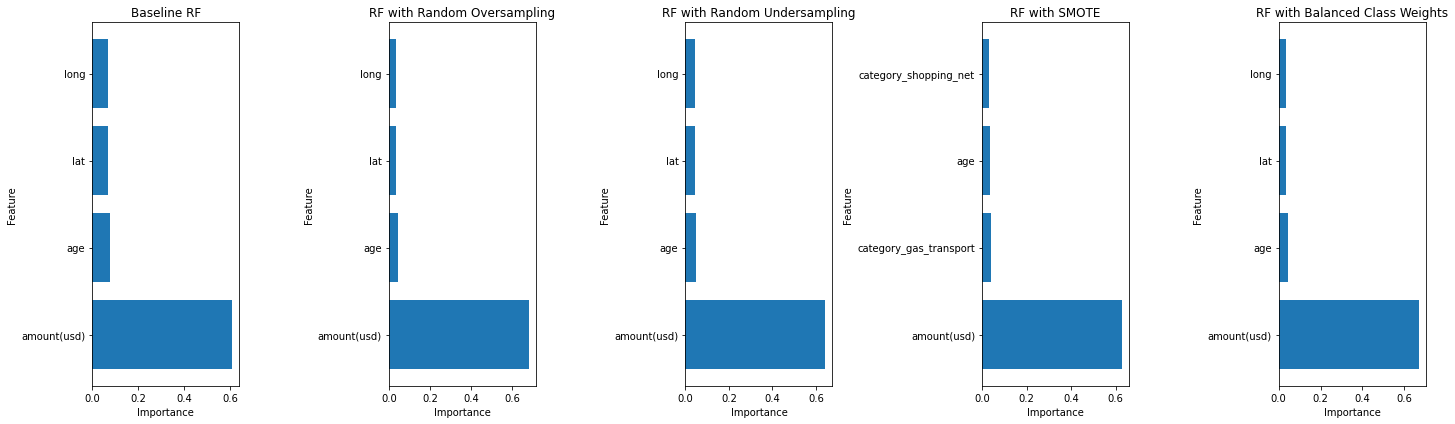

In [74]:
rf_model_with_oversampling = random_overs_pipeline.named_steps['randomforestclassifier']
rf_random_undersampling = random_unders_pipeline.named_steps['randomforestclassifier']
rf_smote = smote_pipeline.named_steps['randomforestclassifier']

# Plot feature importance for all models side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Plot for the baseline RF model
plot_feature_importance(axes[0], baseline_rf, X_train_final)
axes[0].set_title("Baseline RF")

# Plot for the RF with random oversampling model
plot_feature_importance(axes[1], rf_model_with_oversampling, X_train_final)
axes[1].set_title("RF with Random Oversampling")

# Plot for the RF with random undersampling model
plot_feature_importance(axes[2], rf_random_undersampling, X_train_final)
axes[2].set_title("RF with Random Undersampling")

# Plot for the RF with SMOTE model
plot_feature_importance(axes[3], rf_smote, X_train_final)
axes[3].set_title("RF with SMOTE")

# Plot for the RF with balanced class weights model
plot_feature_importance(axes[4], rfb, X_train_final)
axes[4].set_title("RF with Balanced Class Weights")

plt.tight_layout()
plt.show()


We can see the amount (usd) is an important factor across all models, and age, lat and long are also quite common albeit to a smaller extent compared to amount (usd).

## Performance Comparison

In [119]:
predictions = pd.concat([rf_score, under2_rf_score, smote2_rf_score, over2_rf_score, balanced2_rf_score, balanced_rf_score, under_rf_score, smote_rf_score, over_rf_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Weighted F1 Score'], ascending=False)

,Random Forest with,Recall,Precision,Weighted F1 Score,PR AUC,ROC_AUC
0,No Under/Oversampling,0.662176,0.857718,0.997519,0.569720,0.830800
5,Balanced Class Weights,0.648705,0.871866,0.997503,0.567414,0.824103
8,Random Oversampling,0.705699,0.804014,0.997492,0.568926,0.852399
7,SMOTE Oversampling,0.757513,0.706963,0.997151,0.536797,0.877934
2,SMOTE Oversampling using GridSearch,0.468394,0.902196,0.996488,0.425352,0.734064
4,Balanced Class Weights using GridSearch,0.468394,0.902196,0.996488,0.425352,0.734064
3,Random Oversampling using GridSearch,0.866321,0.265988,0.990296,0.231127,0.926901
1,Random undersampling using GridSearch,0.888083,0.203853,0.987109,0.181622,0.934960
6,Random Undersampling,0.960622,0.138918,0.980197,0.133653,0.964720


From the results above, we can see that random oversampling performed slightly better than the base model while the other models are not as good. We can now evaluate the random oversampling model on the test set.

## Evaluate Model on Test Set

In [241]:
random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [243]:
random_overs_pipeline.fit(X_over, y_over)

y_pred_best = random_overs_pipeline.predict(X_test_final)

In [244]:
cm = confusion_matrix(y_test, y_pred_best)

best_rf_Recall = recall_score(y_test, y_pred_best)
best_rf_Precision = precision_score(y_test, y_pred_best)
best_rf_f1 = f1_score(y_test, y_pred_best)
best_rf_accuracy = accuracy_score(y_test, y_pred_best)
best_roc = roc_auc_score(y_test, y_pred_best)
best_prauc = average_precision_score(y_test, y_pred_best)

print(cm)


[[184081    194]
 [   286    679]]


In [247]:
ndf = [(best_rf_Recall, best_rf_Precision, best_rf_f1, best_prauc, best_roc)]

best_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'PR AUC', 'ROC_AUC'])
best_rf_score.insert(0, 'Random Forest with', 'Random Oversampling (Best)')
best_rf_score

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,Random Oversampling (Best),0.703627,0.777778,0.738847,0.548809,0.851287


In [248]:
predictions = pd.concat([rf_score, best_rf_score], ignore_index=True, sort=False)
predictions.sort_values(by=['F1 Score'], ascending=False)

,Random Forest with,Recall,Precision,F1 Score,PR AUC,ROC_AUC
0,No Under/Oversampling,0.662176,0.857718,0.747368,0.569720,0.830800
1,Random Oversampling (Best),0.703627,0.777778,0.738847,0.548809,0.851287
